In [37]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import nibabel as nib

In [38]:
data_folder_path = "./data/"
TRAINING_MODE = False

In [39]:
def fast_display(*lst_images):
    plt.figure(figsize=(16,8))
    nb_images = len(lst_images)
    cols = min(9,nb_images)
    rows = (nb_images // cols) + 1
    for ii,image in enumerate(lst_images):
        plt.subplot(rows,cols,1+ii)
        plt.imshow(image)
    plt.show()


def PrintSlices(img):
    sx,sy,sz,_ = img.shape
    fast_display(img[sx//2,:,:,0],img[:,sy//2,:,0],img[:,:,sz//2,0])



In [40]:
test = nib.load("./data/subject-1-label.img").get_fdata()
print(f"Shape of image: {test.shape}")
print(f"Data type: {test.dtype}")
print(test[0,0,0,:])

Shape of image: (144, 192, 256, 1)
Data type: float64
[0.]


Patient: subject-1-label.img
T1: Coupes saggitales, coronal, axiale de subject-1-label.img


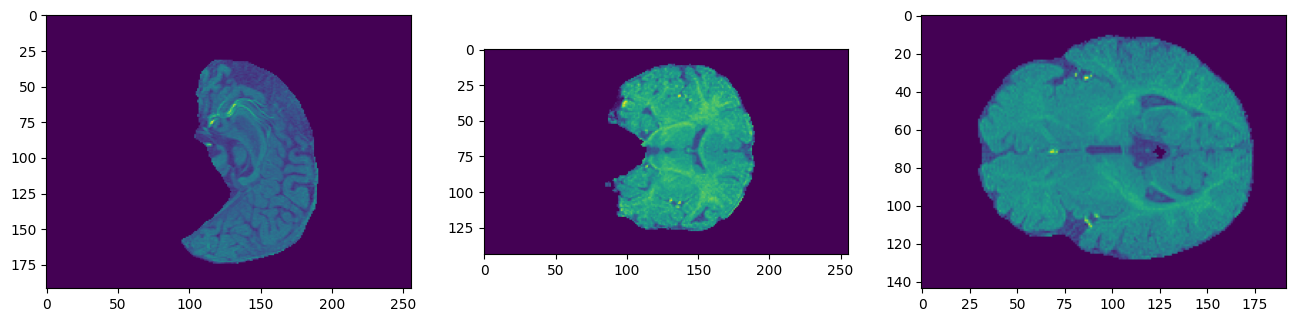

T2: Coupes saggitales, coronal, axiale de subject-1-label.img


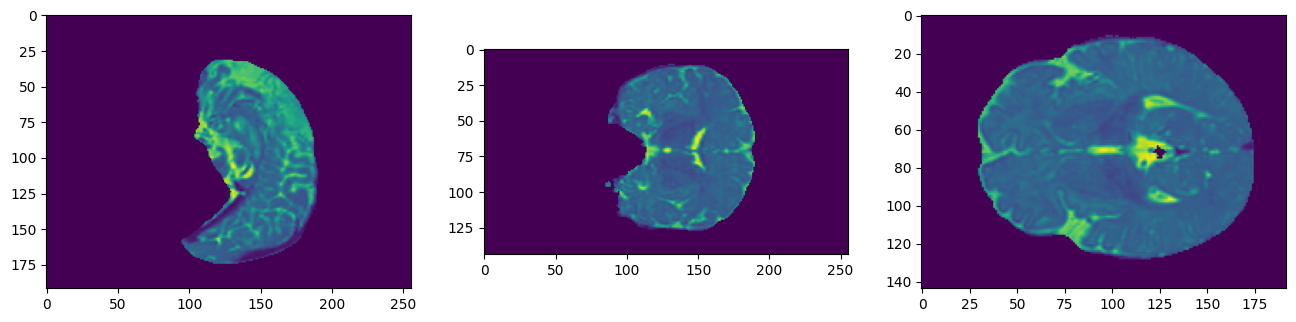

Labels: Coupes saggitales, coronal, axiale de subject-1-label.img


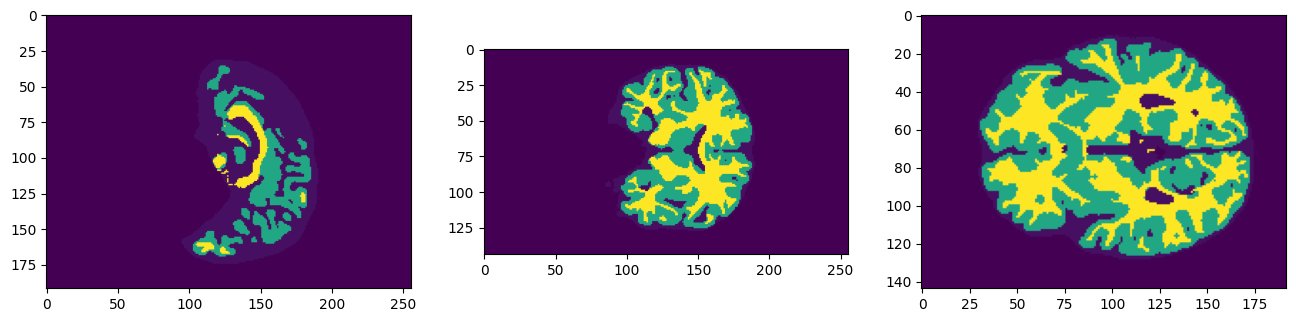

Patient: subject-10-label.img
Patient: subject-2-label.img
Patient: subject-3-label.img
Patient: subject-4-label.img
Patient: subject-5-label.img
Patient: subject-6-label.img
Patient: subject-7-label.img
Patient: subject-8-label.img
Patient: subject-9-label.img


In [41]:
number_of_patient = 0
for filename in os.listdir(data_folder_path):
    if "label" in filename and "hdr" not in filename:
        print(f"Patient: {filename}")
        T1name = filename[:-10]+"-T1.img"
        T1 = nib.load(data_folder_path + T1name).get_fdata()
        if number_of_patient == 0:
            print(f"T1: Coupes saggitales, coronal, axiale de {filename}")
            PrintSlices(T1)
        T2name = filename[:-10]+"-T2.img"
        T2 = nib.load(data_folder_path+ T2name).get_fdata()
        if number_of_patient == 0:
            print(f"T2: Coupes saggitales, coronal, axiale de {filename}")
            PrintSlices(T2)
        labels = nib.load(data_folder_path+filename).get_fdata()
        if number_of_patient == 0:
            print(f"Labels: Coupes saggitales, coronal, axiale de {filename}")
            PrintSlices(labels)
        number_of_patient += 1
    





In [42]:
def ComputeDice(X,Y):
    Xbin = (X > 0)
    Ybin = (Y > 0)
    cardIntersec = np.sum(np.logical_and(Xbin,Ybin))
    cardX = np.sum(Xbin)
    cardY = np.sum(Ybin)

    print(f"cardIntersec: {cardIntersec}")
    print(f"cardX: {cardX}")
    print(f"cardY: {cardY}")

    if cardY + cardX > 0:
        dice = (2.0*cardIntersec) / (cardX + cardY)
        print(f"dice: {dice}")
        return dice
    else:
        return 0

In [43]:
def normalization(img):
    mu = np.mean(img[img>0])
    std = np.std(img[img>0])
    return (img - mu) / std

In [44]:
number_of_patient

10

# Separation des donnes

In [45]:
number_of_patient_training = 6
number_of_patient_validation = 2
number_of_patient_test = 2

On utilise 2D images pour avoir plus de donnees

In [46]:
seullaire = 100

nombre_de_slices_pertinents_training = 0
nombre_de_slices_pertinents_validation = 0

num_patient = 0

for filename in os.listdir(data_folder_path):
    if "label" in filename and "hdr" not in filename:

        if num_patient < number_of_patient_training:
            print(f"PATIENT for training: {filename}")
            labels = nib.load(data_folder_path + filename).get_fdata()

            sx,sy,sz,_ = labels.shape
            labels = np.array(labels).reshape((sx,sy,sz))

            for z in range(0,sz):
                slice = labels[:,:,z]
                if np.sum(slice>=0) >= seullaire:
                    nombre_de_slices_pertinents_training += 1

        if num_patient >= number_of_patient_training and num_patient < number_of_patient_training + number_of_patient_validation:
            print(f"PATIENT for validation: {filename}")
            labels = nib.load(data_folder_path + filename).get_fdata()

            sx,sy,sz,_ = labels.shape
            labels = np.array(labels).reshape((sx,sy,sz))

            for z in range(0,sz):
                slice = labels[:,:,z]
                if np.sum(slice>=0) >= seullaire:
                    nombre_de_slices_pertinents_validation += 1
        num_patient += 1

print(f"nombre_de_slices_pertinents_training: {nombre_de_slices_pertinents_training}")
print(f"nombre_de_slices_pertinents_validation: {nombre_de_slices_pertinents_validation}")


PATIENT for training: subject-1-label.img
PATIENT for training: subject-10-label.img
PATIENT for training: subject-2-label.img
PATIENT for training: subject-3-label.img
PATIENT for training: subject-4-label.img
PATIENT for training: subject-5-label.img
PATIENT for validation: subject-6-label.img
PATIENT for validation: subject-7-label.img
nombre_de_slices_pertinents_training: 1536
nombre_de_slices_pertinents_validation: 512


In [47]:
x_train = np.zeros((nombre_de_slices_pertinents_training,sx,sy,2))
y_train = np.zeros((nombre_de_slices_pertinents_training,sx,sy,1))

x_validation = np.zeros((nombre_de_slices_pertinents_validation,sx,sy,2))
y_validation = np.zeros((nombre_de_slices_pertinents_validation,sx,sy,1))

In [48]:
seullaire = 100

numero_de_slices_pertinents_training = 0
numero_de_slices_pertinents_validation = 0
num_patient = 0

for filename in os.listdir(data_folder_path):
    if "label" in filename and "hdr" not in filename:

        if num_patient < number_of_patient_training:
            print(f"PATIENT for training: {filename}")
            T1name = filename[:-10]+"-T1.img"
            T1 = nib.load(data_folder_path + T1name).get_fdata()
            T2name = filename[:-10]+"-T2.img"
            T2 = nib.load(data_folder_path+ T2name).get_fdata()
            labels = nib.load(data_folder_path + filename).get_fdata()
        
            sx,sy,sz,_ = labels.shape
            labels = np.array(labels).reshape((sx,sy,sz))

            T1NORMALISE = normalization(T1).reshape((sx,sy,sz))
            T2NORMALISE = normalization(T2).reshape((sx,sy,sz))
            LABELSCLIPPED = np.clip(labels,0,1)

            for z in range(0,sz):
                slice = labels[:,:,z]
                if np.sum(slice >= 0) >= seullaire:
                    x_train[numero_de_slices_pertinents_training,:,:,0] = T1NORMALISE[:,:,z]
                    x_train[numero_de_slices_pertinents_training,:,:,1] = T2NORMALISE[:,:,z]
                    y_train[numero_de_slices_pertinents_training,:,:,0] = LABELSCLIPPED[:,:,z]
                    numero_de_slices_pertinents_training += 1
        
        if num_patient >= number_of_patient_training and num_patient < number_of_patient_training + number_of_patient_validation:
            print(f"PATIENT for validation: {filename}")
            T1name = filename[:-10]+"-T1.img"
            T1 = nib.load(data_folder_path + T1name).get_fdata()
            T2name = filename[:-10]+"-T2.img"
            T2 = nib.load(data_folder_path+ T2name).get_fdata()
            labels = nib.load(data_folder_path + filename).get_fdata()
            sx,sy,sz,_ = labels.shape
            labels = np.array(labels).reshape((sx,sy,sz))
            T1NORMALISE = normalization(T1).reshape((sx,sy,sz))
            T2NORMALISE = normalization(T2).reshape((sx,sy,sz))
            VT3D = np.where(labels >= 10,1,0)

            for z in range(0,sz):
                slice = labels[:,:,z]
                if np.sum(slice >= 0) >= seullaire:
                    x_validation[numero_de_slices_pertinents_validation,:,:,0] = T1NORMALISE[:,:,z]
                    x_validation[numero_de_slices_pertinents_validation,:,:,1] = T2NORMALISE[:,:,z]
                    y_validation[numero_de_slices_pertinents_validation,:,:,0] = VT3D[:,:,z]
                    numero_de_slices_pertinents_validation += 1

        num_patient += 1



PATIENT for training: subject-1-label.img
PATIENT for training: subject-10-label.img
PATIENT for training: subject-2-label.img
PATIENT for training: subject-3-label.img
PATIENT for training: subject-4-label.img
PATIENT for training: subject-5-label.img
PATIENT for validation: subject-6-label.img
PATIENT for validation: subject-7-label.img


# Observations des labels

In [49]:
np.unique(labels)

array([  0.,  10., 150., 250.])

0 est le fond

10 est la boite craqnienne

150 est la matiere grise

250 est la matiere blanche

1 er partie

In [50]:
import os
import skimage.io as io
import skimage as trans
import numpy as np
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras import backend as keras
import tensorflow

nbf64 = 8
nbf128 = 16
nbf256 = 32 
nbf512 = 64
nbf1024 = 128

def unet_step1(input_size = (sx,sy,2)):
    inputs = Input(input_size)
    conv1 = Conv2D(nbf64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(nbf64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(nbf128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(nbf128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(nbf256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(nbf256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(nbf512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(nbf512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(nbf1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(nbf1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(nbf512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([up6, conv4], axis = 3)
    conv6 = Conv2D(nbf512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(nbf512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(nbf256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([up7, conv3], axis = 3)
    conv7 = Conv2D(nbf256, 3, activation = 'relu',
                     padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(nbf256, 3, activation = 'relu',
                     padding = 'same', kernel_initializer = 'he_normal')(conv7)
    
    up8 = Conv2D(nbf128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([up8, conv2], axis = 3)
    conv8 = Conv2D(nbf128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(nbf128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(nbf64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([up9, conv1], axis = 3)
    conv9 = Conv2D(nbf64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(nbf64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = Model(inputs = inputs, outputs = conv10)
    model.compile(optimizer = Adam(learning_rate = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])
    model.summary()
    return model


In [51]:
model_step1= unet_step1(input_size = (sx,sy,2))

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 144, 192,  │          0 │ -                 │
│ (InputLayer)        │ 2)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_72 (Conv2D)  │ (None, 144, 192,  │        152 │ input_layer_3[0]… │
│                     │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_73 (Conv2D)  │ (None, 144, 192,  │        584 │ conv2d_72[0][0]   │
│                     │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_12    │ (None, 72, 96, 8) │          0 │ conv2d_73[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_74 (Conv2D)  │ (None, 72, 96,    │      1,168 │ max_pooling2d_12… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_75 (Conv2D)  │ (None, 72, 96,    │      2,320 │ conv2d_74[0][0]   │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_13    │ (None, 36, 48,    │          0 │ conv2d_75[0][0]   │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_76 (Conv2D)  │ (None, 36, 48,    │      4,640 │ max_pooling2d_13… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_77 (Conv2D)  │ (None, 36, 48,    │      9,248 │ conv2d_76[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_14    │ (None, 18, 24,    │          0 │ conv2d_77[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_78 (Conv2D)  │ (None, 18, 24,    │     18,496 │ max_pooling2d_14… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_79 (Conv2D)  │ (None, 18, 24,    │     36,928 │ conv2d_78[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 18, 24,    │          0 │ conv2d_79[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_15    │ (None, 9, 12, 64) │          0 │ dropout_6[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_80 (Conv2D)  │ (None, 9, 12,     │     73,856 │ max_pooling2d_15… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_81 (Conv2D)  │ (None, 9, 12,     │    147,584 │ conv2d_80[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 9, 12,     │          0 │ conv2d_81[0][0] 

 Total params: 485,885 (1.85 MB)

 Trainable params: 485,885 (1.85 MB)

 Non-trainable params: 0 (0.00 B)

part 1.2

In [52]:
if TRAINING_MODE:
    early_stopping = tensorflow.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    model_step1.fit(x_train, y_train, validation_data = (x_validation, y_validation), batch_size = 4, epochs = 50, callbacks=[early_stopping])
    model_step1.save_weights('unet_step1.weights.h5')
else:
    model_step1.load_weights('unet_step1.weights.h5')
# On utilise 2D images pour avoir plus de donnees

d:\programmation\perso\segmentation_cerveau\.venv\lib\site-packages\keras\src\saving\saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 98 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


PATIENT for test: subject-8-label.img
T1, T2, VT, prediction


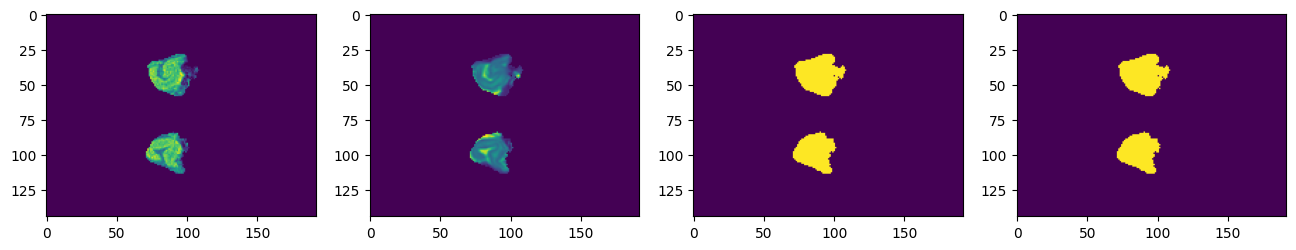

T1, T2, VT, prediction


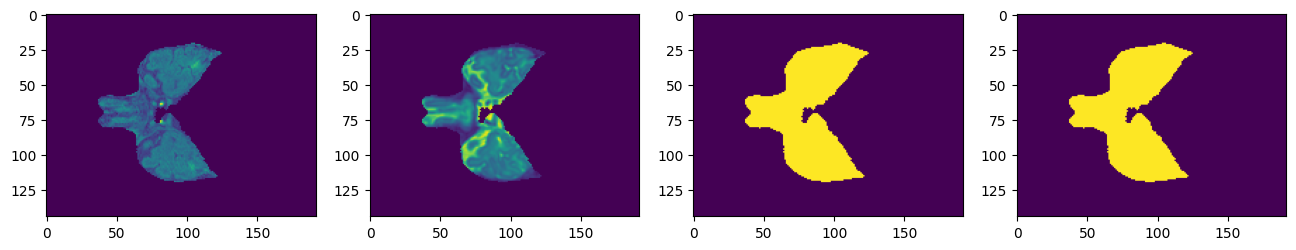

T1, T2, VT, prediction


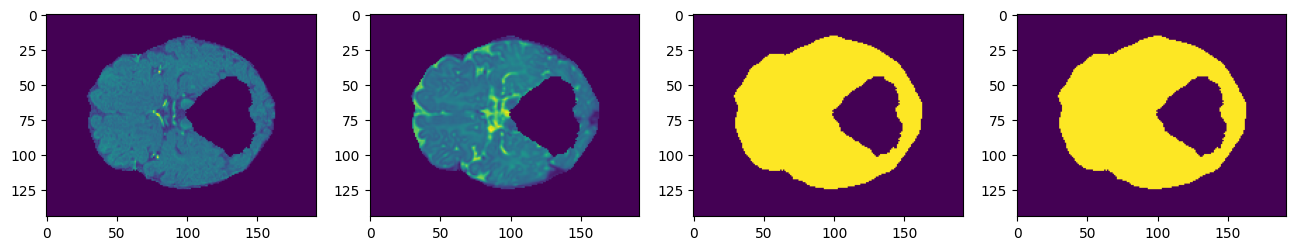

T1, T2, VT, prediction


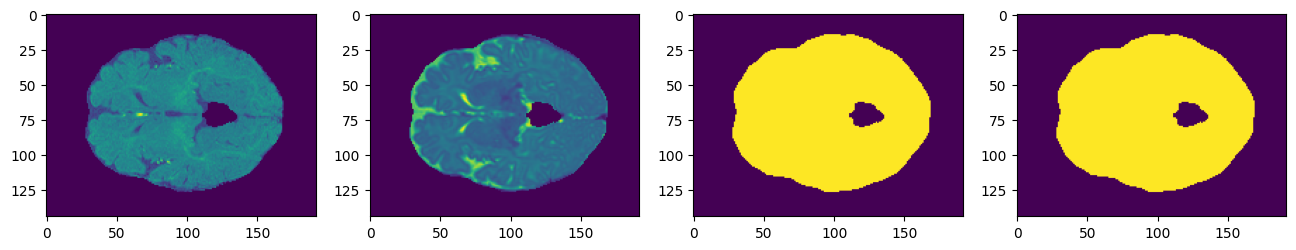

T1, T2, VT, prediction


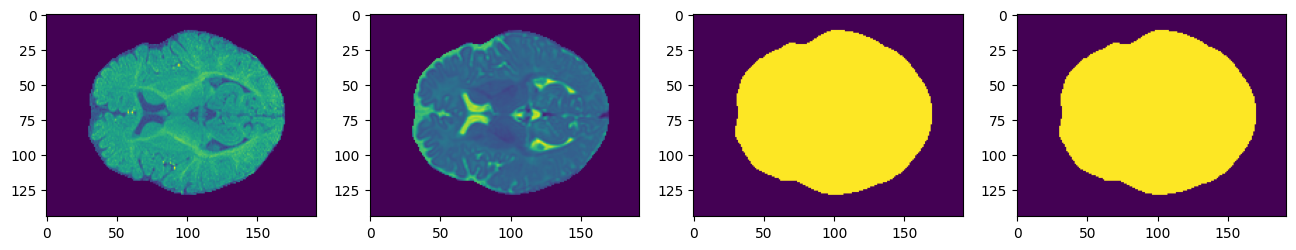

T1, T2, VT, prediction


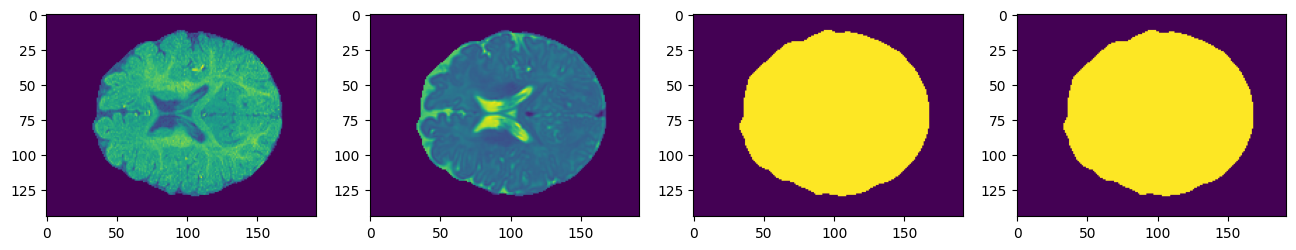

T1, T2, VT, prediction


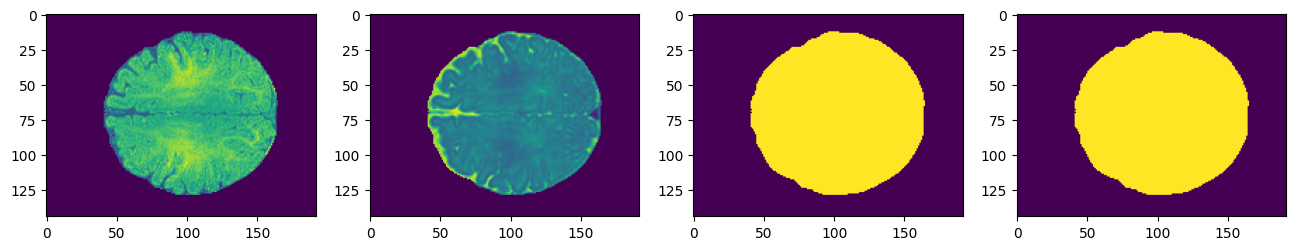

T1, T2, VT, prediction


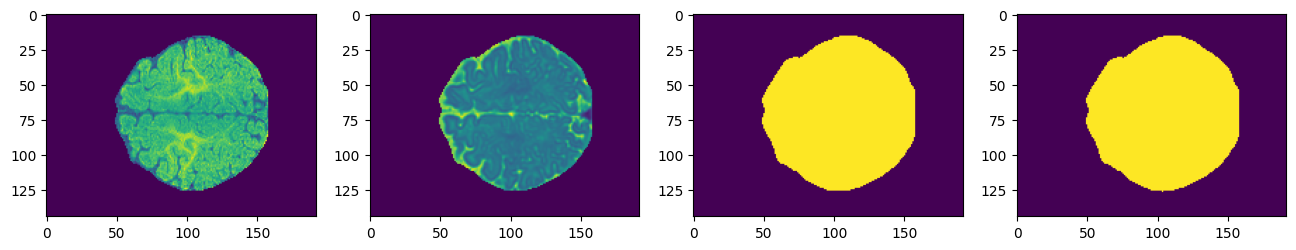

T1, T2, VT, prediction


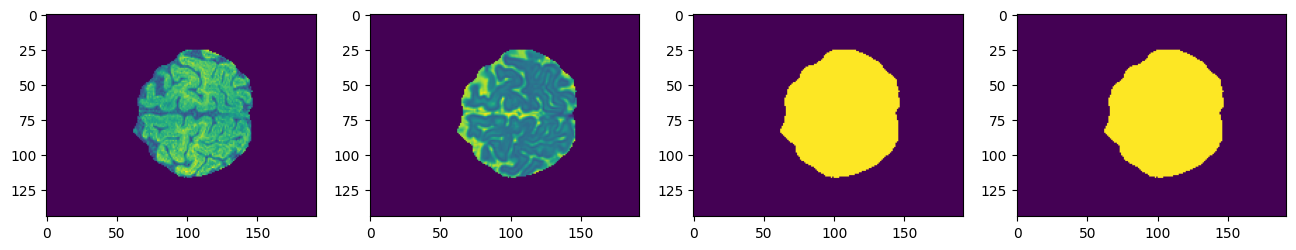

T1, T2, VT, prediction


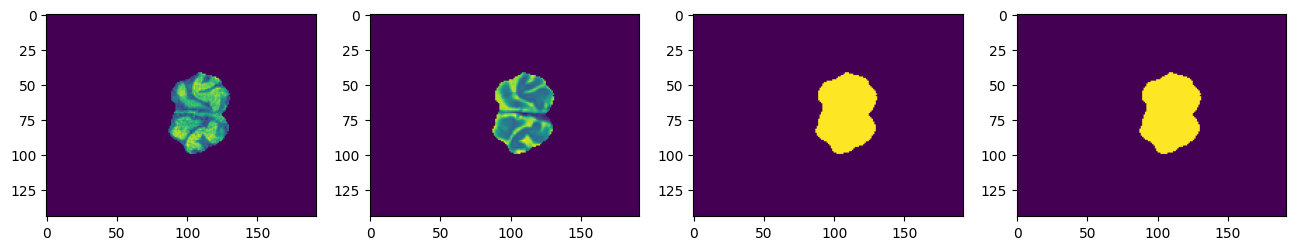

cardIntersec: 786665
cardX: 786704
cardY: 786674
dice: 0.9999694923915295
PATIENT for test: subject-9-label.img
T1, T2, VT, prediction


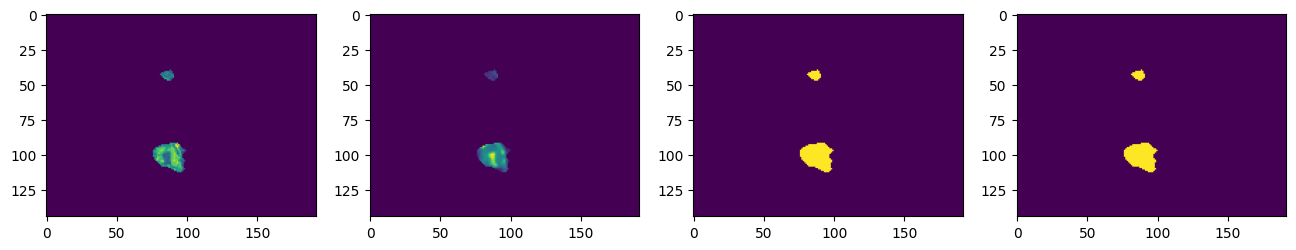

T1, T2, VT, prediction


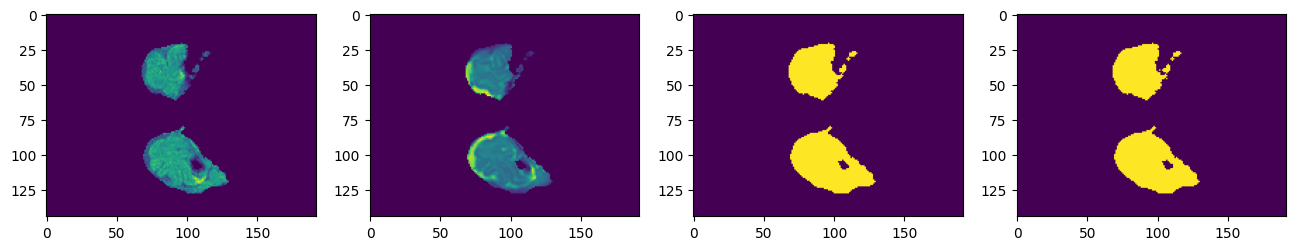

T1, T2, VT, prediction


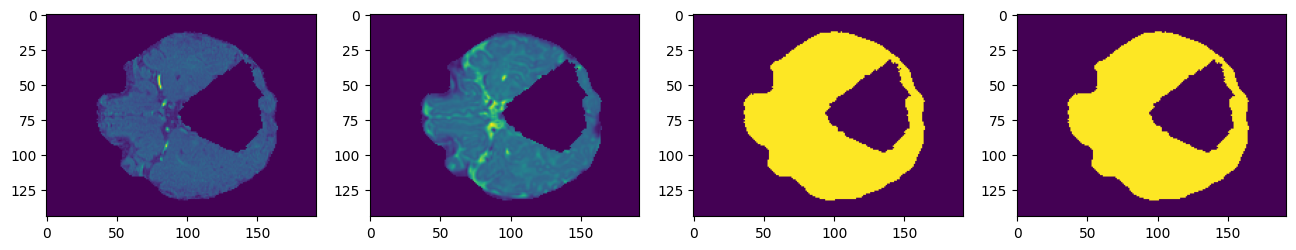

T1, T2, VT, prediction


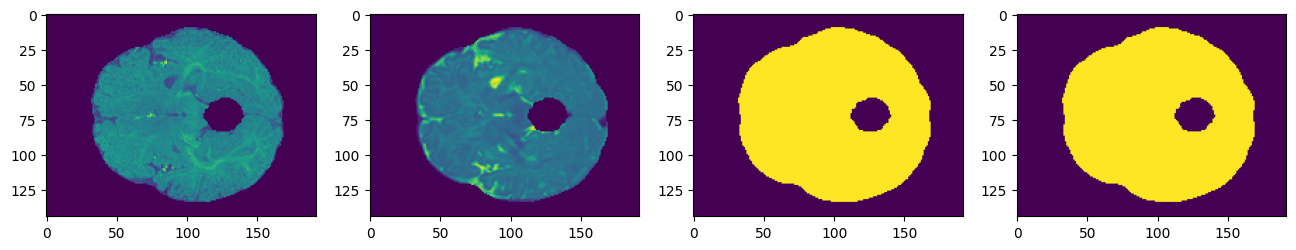

T1, T2, VT, prediction


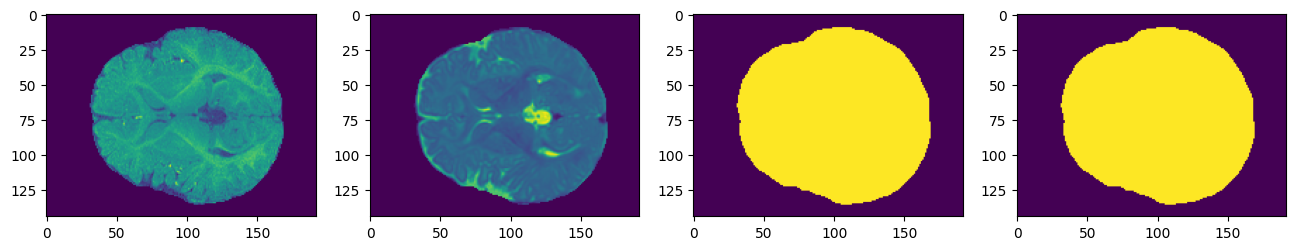

T1, T2, VT, prediction


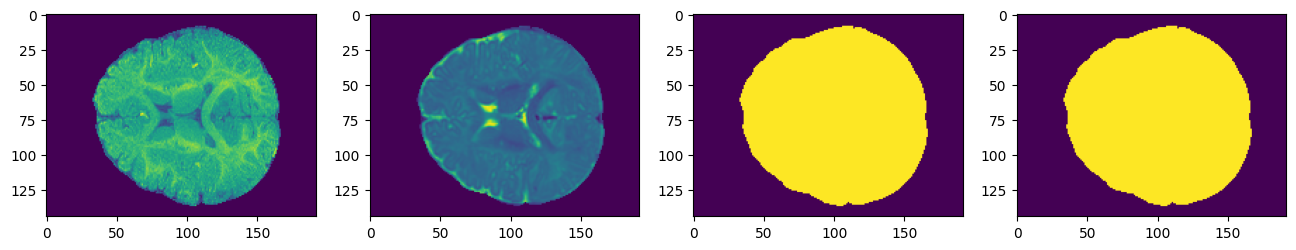

T1, T2, VT, prediction


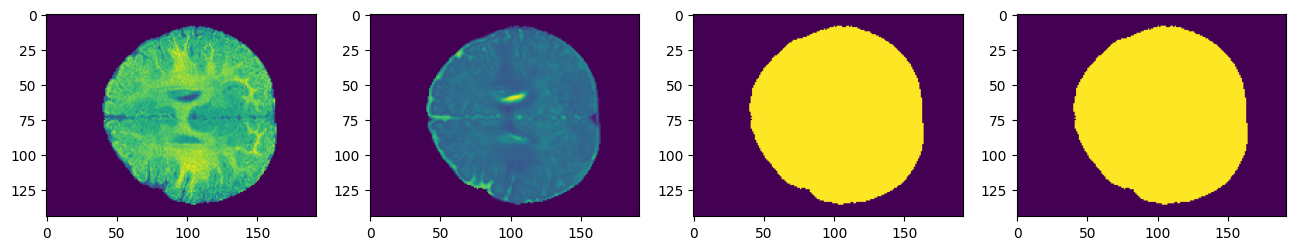

T1, T2, VT, prediction


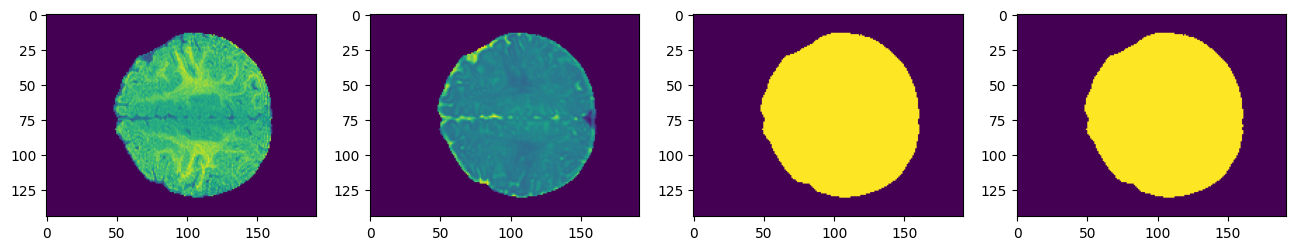

T1, T2, VT, prediction


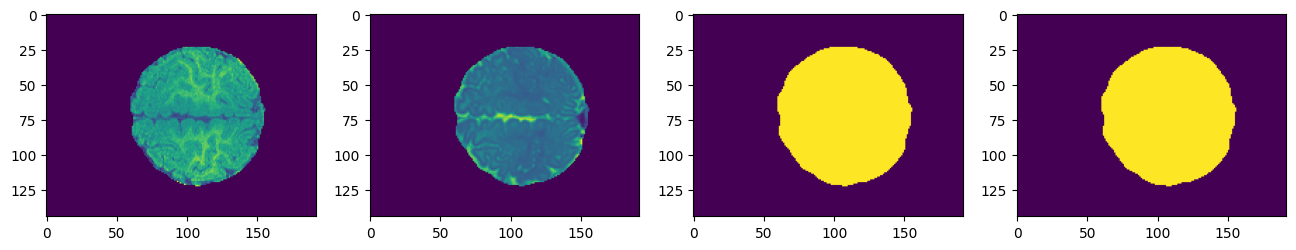

T1, T2, VT, prediction


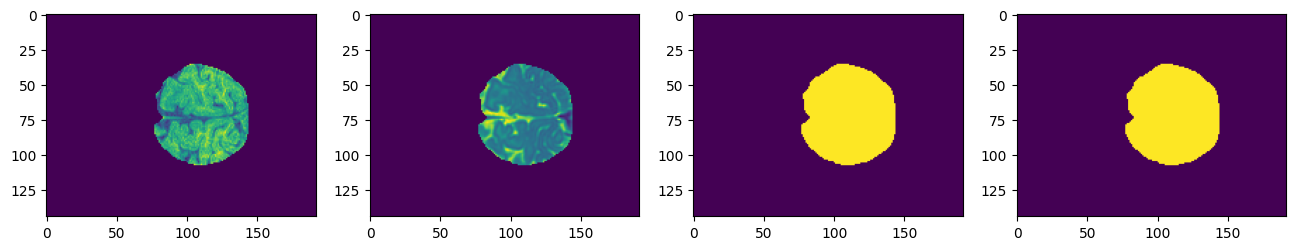

cardIntersec: 849824
cardX: 849872
cardY: 849853
dice: 0.9999546985541778
liste_dices_crane: [0.99996949 0.9999547 ]
Mean dice cranienne: 0.9999620954728536


In [53]:
liste_dices_crane = np.zeros((number_of_patient_test,))

numpatient = 0
num_patient_test = 0
for filename in os.listdir(data_folder_path):

    if "label" in filename and "hdr" not in filename:
        if numpatient >= number_of_patient_training + number_of_patient_validation and numpatient < number_of_patient_training + number_of_patient_validation + number_of_patient_test:
            print(f"PATIENT for test: {filename}")
            T1name = filename[:-10]+"-T1.img"
            T1 = nib.load(data_folder_path + T1name).get_fdata()
            T2name = filename[:-10]+"-T2.img"
            T2 = nib.load(data_folder_path+ T2name).get_fdata()
            labels = nib.load(data_folder_path + filename).get_fdata()
        
            sx,sy,sz,_ = labels.shape
            labels = np.array(labels).reshape((sx,sy,sz))

            prediction3D_10 = np.zeros((sx,sy,sz))

            T1NORMALISE = normalization(T1).reshape((sx,sy,sz))
            T2NORMALISE = normalization(T2).reshape((sx,sy,sz))
            LABELSCLIPPED = np.clip(labels,0,1)

            VT3D = np.where(labels >= 10,1,0)


            for z in range(0,sz):
                inputreseau = np.zeros((1,sx,sy,2))
                inputreseau[0,:,:,0] = T1NORMALISE[:,:,z]
                inputreseau[0,:,:,1] = T2NORMALISE[:,:,z]
                prediction10 = np.round(model_step1.predict(inputreseau,verbose=0)).reshape((sx,sy))
                prediction3D_10[:,:,z] = np.copy(prediction10)

                prediction_to_plot = np.copy(prediction10)
                VT_to_plot = np.copy(LABELSCLIPPED[:,:,z])
                if z%10 == 0 and np.sum(VT_to_plot) > 0:
                    VT_to_plot[0,0] = 1.0
                    prediction_to_plot[0,0] = 1.0
                    print("T1, T2, VT, prediction")
                    fast_display(T1NORMALISE[:,:,z],T2NORMALISE[:,:,z],VT_to_plot,prediction_to_plot)
            dice_crane = ComputeDice(prediction3D_10, VT3D)
            liste_dices_crane[num_patient_test] = dice_crane
            num_patient_test += 1

        numpatient += 1
print(f"liste_dices_crane: {liste_dices_crane}")
print(f"Mean dice cranienne: {np.mean(liste_dices_crane)}") 


Segmentation du cerveau

In [54]:
seullaire = 100

nombre_de_slices_pertinents_training = 0
nombre_de_slices_pertinents_validation = 0

num_patient = 0
for filename in os.listdir(data_folder_path):
    if "label" in filename and "hdr" not in filename:

        if num_patient < number_of_patient_training:
            print(f"PATIENT for training: {filename}")
            labels = nib.load(data_folder_path + filename).get_fdata()

            sx,sy,sz,_ = labels.shape
            labels = np.array(labels).reshape((sx,sy,sz))

            for z in range(0,sz):
                slice = labels[:,:,z]
                if np.sum(slice>=0) >= seullaire:
                    nombre_de_slices_pertinents_training += 1

        if num_patient >= number_of_patient_training and num_patient < number_of_patient_training + number_of_patient_validation:
            print(f"PATIENT for validation: {filename}")
            labels = nib.load(data_folder_path + filename).get_fdata()

            sx,sy,sz,_ = labels.shape
            labels = np.array(labels).reshape((sx,sy,sz))

            for z in range(0,sz):
                slice = labels[:,:,z]
                if np.sum(slice>=0) >= seullaire:
                    nombre_de_slices_pertinents_validation += 1
        num_patient += 1

print(f"nombre_de_slices_pertinents_training: {nombre_de_slices_pertinents_training}")
print(f"nombre_de_slices_pertinents_validation: {nombre_de_slices_pertinents_validation}")

PATIENT for training: subject-1-label.img
PATIENT for training: subject-10-label.img
PATIENT for training: subject-2-label.img
PATIENT for training: subject-3-label.img
PATIENT for training: subject-4-label.img
PATIENT for training: subject-5-label.img
PATIENT for validation: subject-6-label.img
PATIENT for validation: subject-7-label.img
nombre_de_slices_pertinents_training: 1536
nombre_de_slices_pertinents_validation: 512


In [55]:
x_train = np.zeros((nombre_de_slices_pertinents_training,sx,sy,3))
y_train = np.zeros((nombre_de_slices_pertinents_training,sx,sy,1))

x_validation = np.zeros((nombre_de_slices_pertinents_validation,sx,sy,3))
y_validation = np.zeros((nombre_de_slices_pertinents_validation,sx,sy,1))

In [56]:

seullaire = 100
numero_de_slices_pertinents_training = 0
numero_de_slices_pertinents_validation = 0

num_patient = 0

for filename in os.listdir(data_folder_path):
    if "label" in filename and "hdr" not in filename:

        if num_patient < number_of_patient_training:
            print(f"PATIENT for training: {filename}")
            T1name = filename[:-10]+"-T1.img"
            T1 = nib.load(data_folder_path + T1name).get_fdata()
            T2name = filename[:-10]+"-T2.img"
            T2 = nib.load(data_folder_path+ T2name).get_fdata()
            labels = nib.load(data_folder_path + filename).get_fdata()
        
            sx,sy,sz,_ = labels.shape
            labels = np.array(labels).reshape((sx,sy,sz))

            T1NORMALISE = normalization(T1).reshape((sx,sy,sz))
            T2NORMALISE = normalization(T2).reshape((sx,sy,sz))
            VT10 = np.where(labels >= 10,1,0).reshape((sx,sy,sz))
            VT150 = np.where(labels >= 150,1,0).reshape((sx,sy,sz))

            for z in range(0,sz):
                slice = labels[:,:,z]
                if np.sum(slice >= 0) >= seullaire:
                    x_train[numero_de_slices_pertinents_training,:,:,0] = T1NORMALISE[:,:,z]
                    x_train[numero_de_slices_pertinents_training,:,:,1] = T2NORMALISE[:,:,z]
                    x_train[numero_de_slices_pertinents_training,:,:,2] = VT10[:,:,z]
                    y_train[numero_de_slices_pertinents_training,:,:,0] = VT150[:,:,z]
                    numero_de_slices_pertinents_training += 1

        if num_patient >= number_of_patient_training and num_patient < number_of_patient_training + number_of_patient_validation:
            print(f"PATIENT for validation: {filename}")
            T1name = filename[:-10]+"-T1.img"
            T1 = nib.load(data_folder_path + T1name).get_fdata()
            T2name = filename[:-10]+"-T2.img"
            T2 = nib.load(data_folder_path+ T2name).get_fdata()
            labels = nib.load(data_folder_path + filename).get_fdata()
            sx,sy,sz,_ = labels.shape
            labels = np.array(labels).reshape((sx,sy,sz))
            T1NORMALISE = normalization(T1).reshape((sx,sy,sz))
            T2NORMALISE = normalization(T2).reshape((sx,sy,sz))
            VT10 = np.where(labels >= 10,1,0).reshape((sx,sy,sz))
            VT150 = np.where(labels >= 150,1,0).reshape((sx,sy,sz))

            for z in range(0,sz):
                slice = labels[:,:,z]
                if np.sum(slice >= 0) >= seullaire:
                    x_validation[numero_de_slices_pertinents_validation,:,:,0] = T1NORMALISE[:,:,z]
                    x_validation[numero_de_slices_pertinents_validation,:,:,1] = T2NORMALISE[:,:,z]
                    x_validation[numero_de_slices_pertinents_validation,:,:,2] = VT10[:,:,z]
                    y_validation[numero_de_slices_pertinents_validation,:,:,0] = VT150[:,:,z]
                    numero_de_slices_pertinents_validation += 1
        num_patient += 1

print(f"x_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"x_validation shape: {x_validation.shape}")
print(f"y_validation shape: {y_validation.shape}")


PATIENT for training: subject-1-label.img
PATIENT for training: subject-10-label.img
PATIENT for training: subject-2-label.img
PATIENT for training: subject-3-label.img
PATIENT for training: subject-4-label.img
PATIENT for training: subject-5-label.img
PATIENT for validation: subject-6-label.img
PATIENT for validation: subject-7-label.img
x_train shape: (1536, 144, 192, 3)
y_train shape: (1536, 144, 192, 1)
x_validation shape: (512, 144, 192, 3)
y_validation shape: (512, 144, 192, 1)


On cree le 2eme reseau

In [57]:
nbf64 = 8
nbf128 = 16
nbf256 = 32
nbf512 = 64
nbf1024 = 128

def unet_step2(input_size = (sx,sy,3)):
    inputs = Input(input_size)
    conv1 = Conv2D(nbf64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(nbf64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(nbf128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(nbf128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(nbf256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(nbf256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(nbf512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(nbf512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(nbf1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(nbf1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(nbf512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([up6, conv4], axis = 3)  
    conv6 = Conv2D(nbf512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(nbf512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)
    up7 = Conv2D(nbf256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([up7, conv3], axis = 3)
    conv7 = Conv2D(nbf256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(nbf256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)
    up8 = Conv2D(nbf128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([up8, conv2], axis = 3)
    conv8 = Conv2D(nbf128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(nbf128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)
    up9 = Conv2D(nbf64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([up9, conv1], axis = 3)
    conv9 = Conv2D(nbf64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(nbf64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = Model(inputs = inputs, outputs = conv10)
    model.compile(optimizer = Adam(learning_rate = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])
    model.summary()
    return model
    

In [58]:
model_step2= unet_step2(input_size = (sx,sy,3))

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 144, 192,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_96 (Conv2D)  │ (None, 144, 192,  │        224 │ input_layer_4[0]… │
│                     │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_97 (Conv2D)  │ (None, 144, 192,  │        584 │ conv2d_96[0][0]   │
│                     │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_16    │ (None, 72, 96, 8) │          0 │ conv2d_97[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_98 (Conv2D)  │ (None, 72, 96,    │      1,168 │ max_pooling2d_16… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_99 (Conv2D)  │ (None, 72, 96,    │      2,320 │ conv2d_98[0][0]   │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_17    │ (None, 36, 48,    │          0 │ conv2d_99[0][0]   │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_100 (Conv2D) │ (None, 36, 48,    │      4,640 │ max_pooling2d_17… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_101 (Conv2D) │ (None, 36, 48,    │      9,248 │ conv2d_100[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_18    │ (None, 18, 24,    │          0 │ conv2d_101[0][0]  │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_102 (Conv2D) │ (None, 18, 24,    │     18,496 │ max_pooling2d_18… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_103 (Conv2D) │ (None, 18, 24,    │     36,928 │ conv2d_102[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 18, 24,    │          0 │ conv2d_103[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_19    │ (None, 9, 12, 64) │          0 │ dropout_8[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_104 (Conv2D) │ (None, 9, 12,     │     73,856 │ max_pooling2d_19… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_105 (Conv2D) │ (None, 9, 12,     │    147,584 │ conv2d_104[0][0]  │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, 9, 12,     │          0 │ conv2d_105[0][0]

 Total params: 485,957 (1.85 MB)

 Trainable params: 485,957 (1.85 MB)

 Non-trainable params: 0 (0.00 B)

In [59]:
if TRAINING_MODE:
    early_stopping = tensorflow.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    model_step2.fit(x_train, y_train, validation_data = (x_validation, y_validation), batch_size = 4, epochs = 50, callbacks=[early_stopping])
    model_step2.save_weights('unet_step2.weights.h5')
else:
    model_step2.load_weights('unet_step2.weights.h5')

On verifie le second reseau

PATIENT for test: subject-8-label.img
T1, T2, VT, prediction


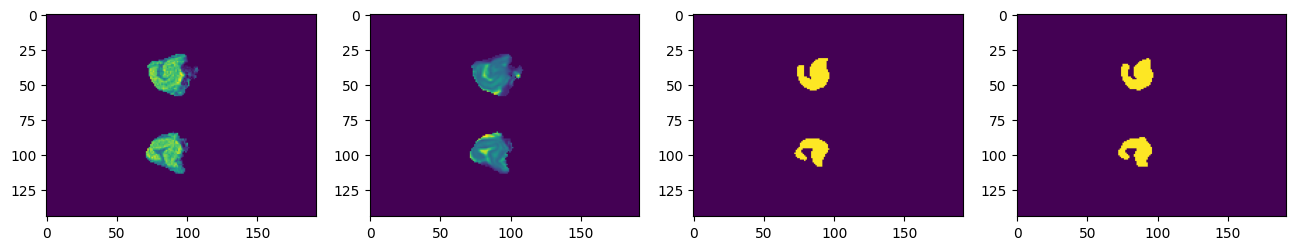

T1, T2, VT, prediction


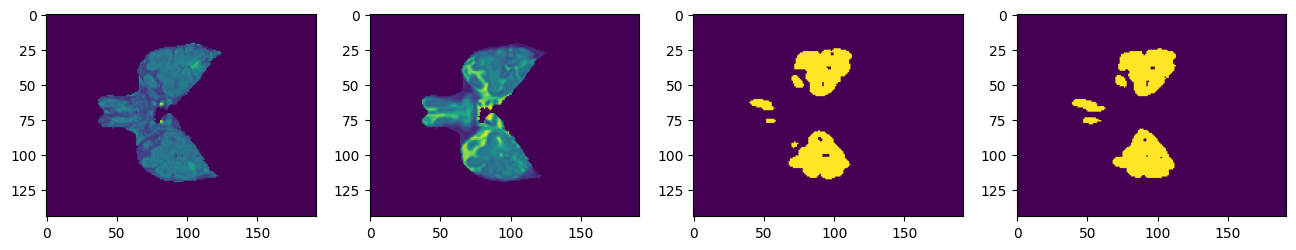

T1, T2, VT, prediction


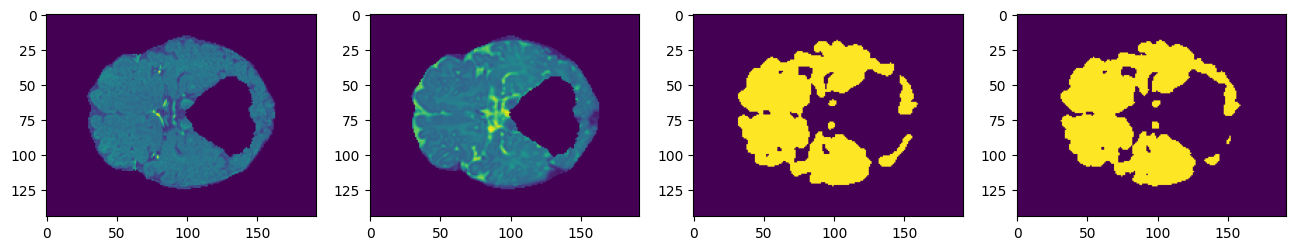

T1, T2, VT, prediction


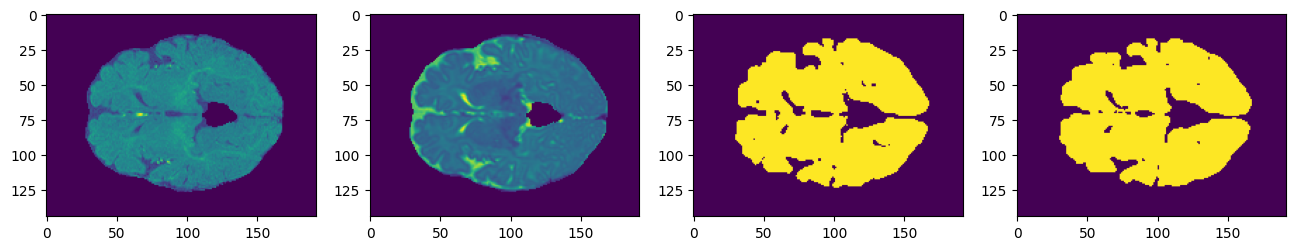

T1, T2, VT, prediction


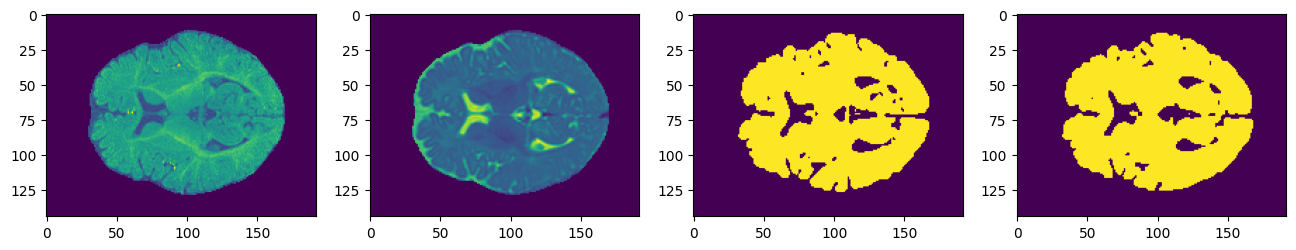

T1, T2, VT, prediction


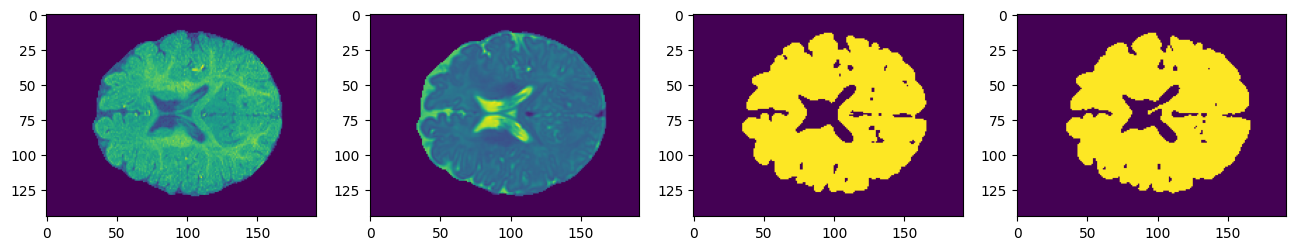

T1, T2, VT, prediction


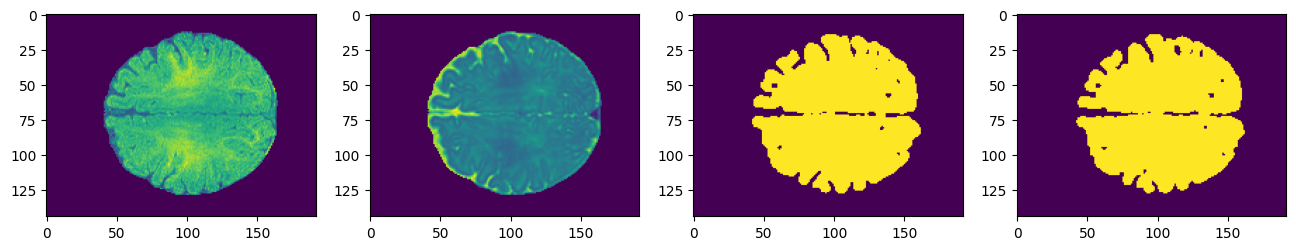

T1, T2, VT, prediction


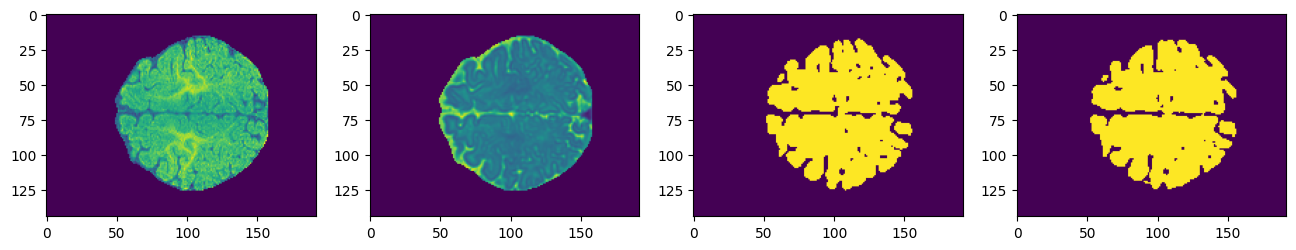

T1, T2, VT, prediction


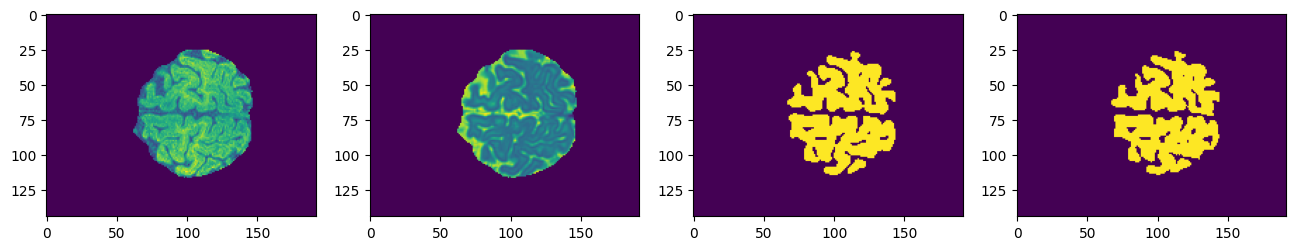

T1, T2, VT, prediction


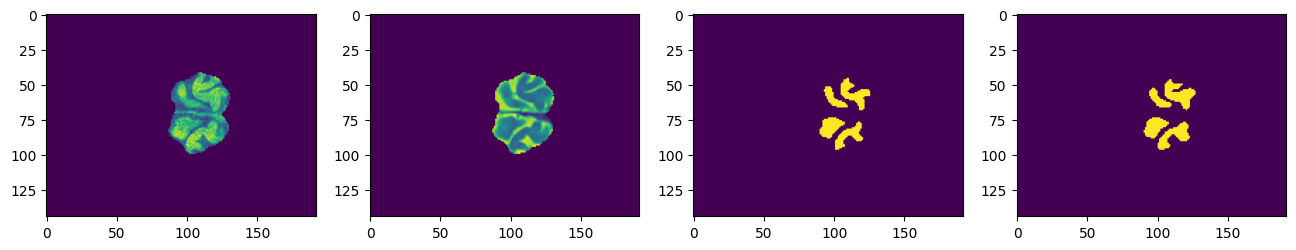

cardIntersec: 590110
cardX: 607298
cardY: 602636
dice: 0.9754416356594657
PATIENT for test: subject-9-label.img
T1, T2, VT, prediction


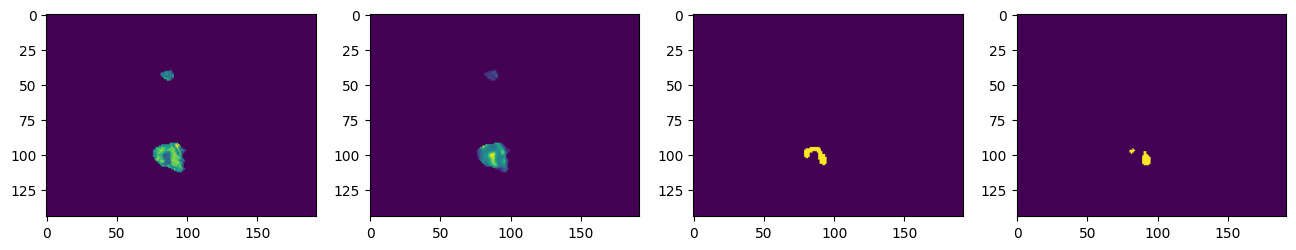

T1, T2, VT, prediction


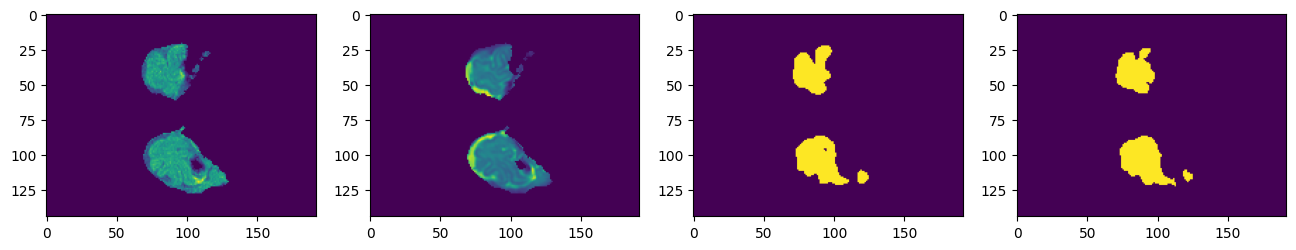

T1, T2, VT, prediction


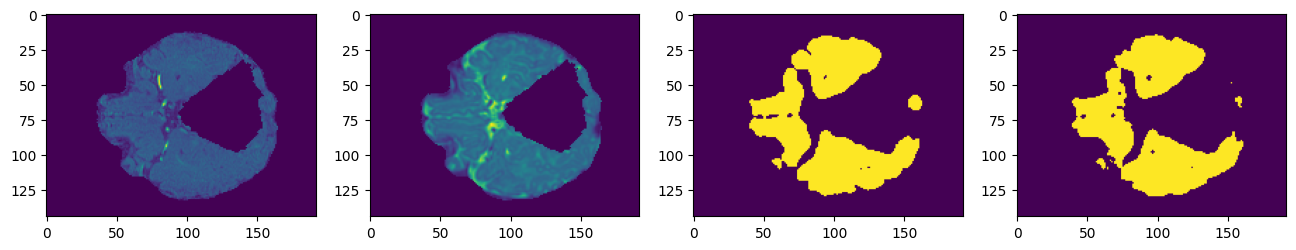

T1, T2, VT, prediction


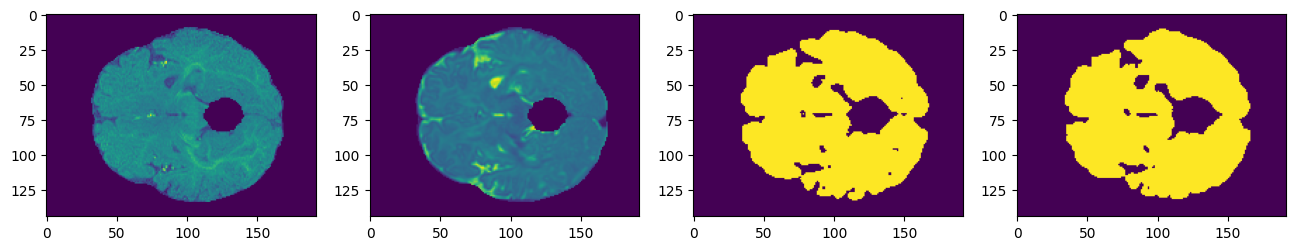

T1, T2, VT, prediction


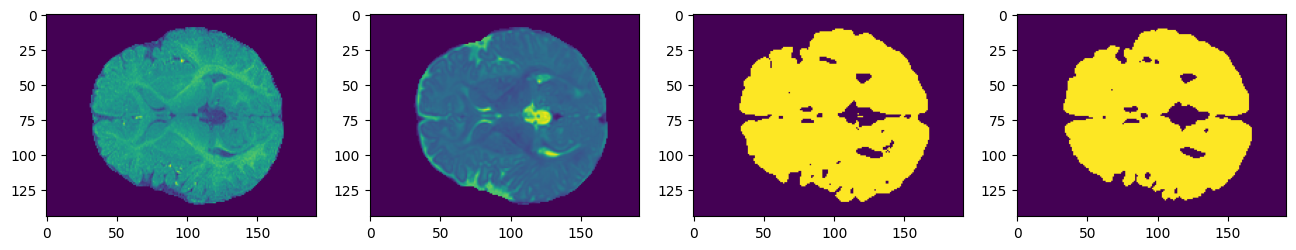

T1, T2, VT, prediction


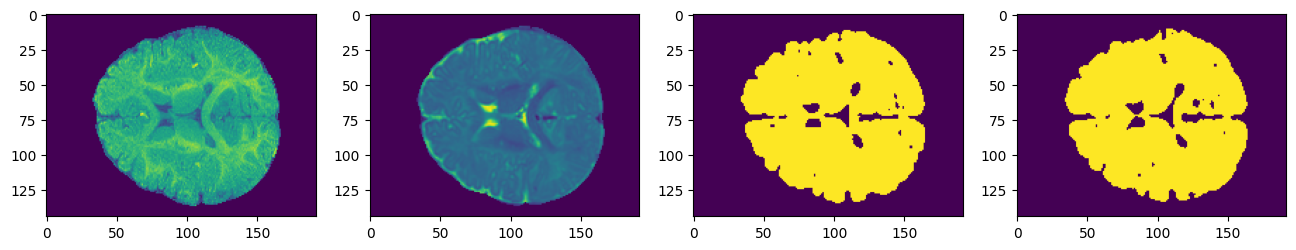

T1, T2, VT, prediction


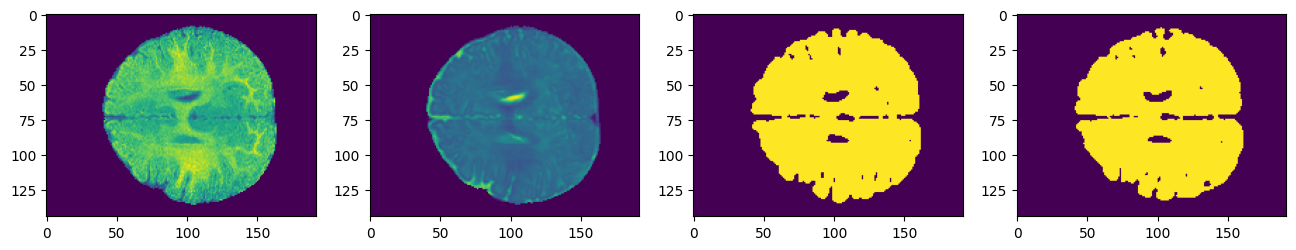

T1, T2, VT, prediction


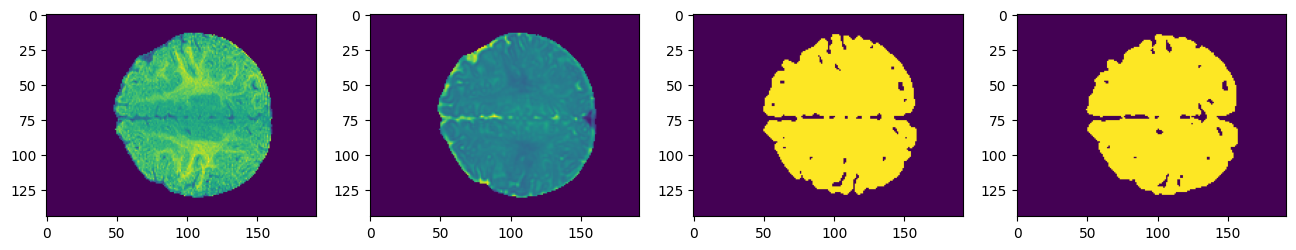

T1, T2, VT, prediction


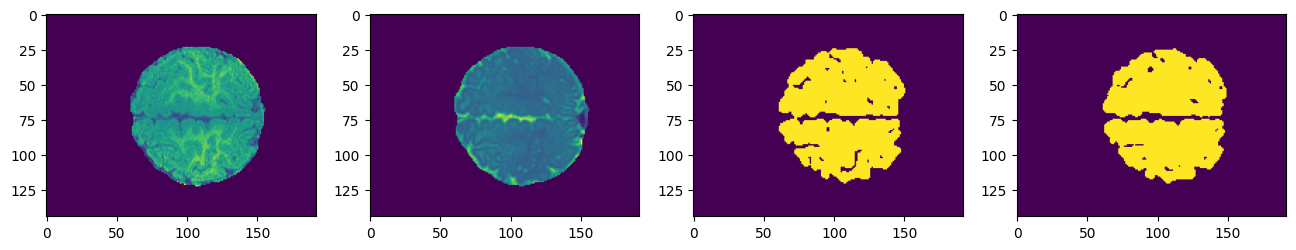

T1, T2, VT, prediction


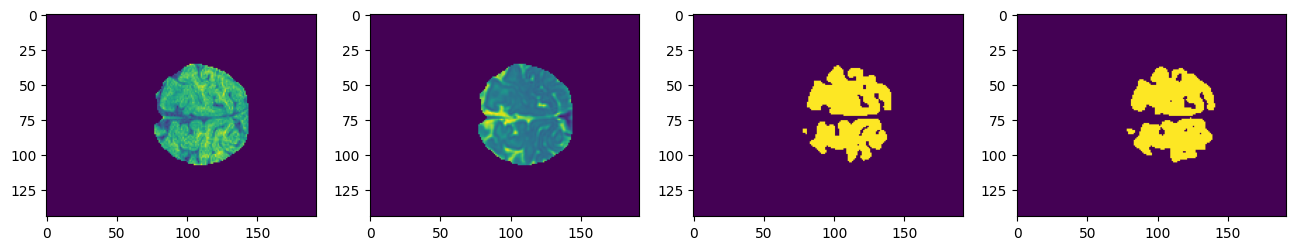

cardIntersec: 676363
cardX: 690735
cardY: 697521
dice: 0.974406737662218
listes_dices_brain: [0.97544164 0.97440674]
Mean dice brain: 0.9749241866608418


In [60]:
listes_dices_brain = np.zeros((number_of_patient_test,))

numpatient = 0
num_patient_test = 0
for filename in os.listdir(data_folder_path):

    if "label" in filename and "hdr" not in filename:
        if numpatient >= number_of_patient_training + number_of_patient_validation and numpatient < number_of_patient_training + number_of_patient_validation + number_of_patient_test:
            print(f"PATIENT for test: {filename}")
            T1name = filename[:-10]+"-T1.img"
            T1 = nib.load(data_folder_path + T1name).get_fdata()
            T2name = filename[:-10]+"-T2.img"
            T2 = nib.load(data_folder_path+ T2name).get_fdata()
            labels = nib.load(data_folder_path + filename).get_fdata()
        
            sx,sy,sz,_ = labels.shape
            labels = np.array(labels).reshape((sx,sy,sz))

            prediction3D_150 = np.zeros((sx,sy,sz))

            T1NORMALISE = normalization(T1).reshape((sx,sy,sz))
            T2NORMALISE = normalization(T2).reshape((sx,sy,sz))
            VT3D_10 = np.where(labels >= 10,1,0)
            VT3D_150 = np.where(labels >= 150,1,0)

            prediction_3D = np.zeros((sx,sy,sz))

            for z in range(0,sz):
                inputreseau1 = np.zeros((1,sx,sy,2))
                inputreseau1[0,:,:,0] = T1NORMALISE[:,:,z]
                inputreseau1[0,:,:,1] = T2NORMALISE[:,:,z]
                prediction10 = np.round(model_step1.predict(inputreseau1,verbose=0)).reshape((sx,sy))

                inputreseau2 = np.zeros((1,sx,sy,3))
                inputreseau2[0,:,:,0] = T1NORMALISE[:,:,z]
                inputreseau2[0,:,:,1] = T2NORMALISE[:,:,z]
                inputreseau2[0,:,:,2] = prediction10
                prediction150 = np.round(model_step2.predict(inputreseau2,verbose=0)).reshape((sx,sy))
                prediction3D_150[:,:,z] = np.copy(prediction150)

                prediction_to_plot = np.copy(prediction150)
                VT_to_plot = np.copy(VT3D_150[:,:,z])
                if z%10 == 0 and np.sum(VT_to_plot) > 0:
                    VT_to_plot[0,0] = 1.0
                    prediction_to_plot[0,0] = 1.0
                    print("T1, T2, VT, prediction")
                    fast_display(T1NORMALISE[:,:,z],T2NORMALISE[:,:,z],VT_to_plot,prediction_to_plot)
            dice_brain = ComputeDice(prediction3D_150, VT3D_150)
            listes_dices_brain[num_patient_test] = dice_brain
            num_patient_test += 1
        numpatient += 1
print(f"listes_dices_brain: {listes_dices_brain}")
print(f"Mean dice brain: {np.mean(listes_dices_brain)}")

Segmentation de la matiere blanche

In [61]:
seullaire = 100

nombre_de_slices_pertinents_training = 0
nombre_de_slices_pertinents_validation = 0

num_patient = 0
for filename in os.listdir(data_folder_path):
    if "label" in filename and "hdr" not in filename:

        if num_patient < number_of_patient_training:
            print(f"PATIENT for training: {filename}")
            labels = nib.load(data_folder_path + filename).get_fdata()

            sx,sy,sz,_ = labels.shape
            labels = np.array(labels).reshape((sx,sy,sz))

            for z in range(0,sz):
                slice = labels[:,:,z]
                if np.sum(slice>=0) >= seullaire:
                    nombre_de_slices_pertinents_training += 1

        if num_patient >= number_of_patient_training and num_patient < number_of_patient_training + number_of_patient_validation:
            print(f"PATIENT for validation: {filename}")
            labels = nib.load(data_folder_path + filename).get_fdata()

            sx,sy,sz,_ = labels.shape
            labels = np.array(labels).reshape((sx,sy,sz))

            for z in range(0,sz):
                slice = labels[:,:,z]
                if np.sum(slice>=0) >= seullaire:
                    nombre_de_slices_pertinents_validation += 1
        num_patient += 1
print(f"nombre_de_slices_pertinents_training: {nombre_de_slices_pertinents_training}")
print(f"nombre_de_slices_pertinents_validation: {nombre_de_slices_pertinents_validation}")

PATIENT for training: subject-1-label.img
PATIENT for training: subject-10-label.img
PATIENT for training: subject-2-label.img
PATIENT for training: subject-3-label.img
PATIENT for training: subject-4-label.img
PATIENT for training: subject-5-label.img
PATIENT for validation: subject-6-label.img
PATIENT for validation: subject-7-label.img
nombre_de_slices_pertinents_training: 1536
nombre_de_slices_pertinents_validation: 512


In [62]:
x_train = np.zeros((nombre_de_slices_pertinents_training,sx,sy,4))
y_train = np.zeros((nombre_de_slices_pertinents_training,sx,sy,1))

x_validation = np.zeros((nombre_de_slices_pertinents_validation,sx,sy,4))
y_validation = np.zeros((nombre_de_slices_pertinents_validation,sx,sy,1))



In [63]:
seullaire = 100
nombre_de_slices_pertinents_training = 0
nombre_de_slices_pertinents_validation = 0

num_patient = 0
for filename in os.listdir(data_folder_path):
    if "label" in filename and "hdr" not in filename:

        if num_patient < number_of_patient_training:
            print(f"PATIENT for training: {filename}")
            T1name = filename[:-10]+"-T1.img"
            T1 = nib.load(data_folder_path + T1name).get_fdata()
            T2name = filename[:-10]+"-T2.img"
            T2 = nib.load(data_folder_path+ T2name).get_fdata()
            labels = nib.load(data_folder_path + filename).get_fdata()
        
            sx,sy,sz,_ = labels.shape
            labels = np.array(labels).reshape((sx,sy,sz))

            T1NORMALISE = normalization(T1).reshape((sx,sy,sz))
            T2NORMALISE = normalization(T2).reshape((sx,sy,sz))
            VT10 = np.where(labels >= 10,1,0).reshape((sx,sy,sz))
            VT150 = np.where(labels >= 150,1,0).reshape((sx,sy,sz))
            VT250 = np.where(labels >= 250,1,0).reshape((sx,sy,sz))

            for z in range(0,sz):
                slice = labels[:,:,z]
                if np.sum(slice >= 0) >= seullaire:
                    x_train[nombre_de_slices_pertinents_training,:,:,0] = T1NORMALISE[:,:,z]
                    x_train[nombre_de_slices_pertinents_training,:,:,1] = T2NORMALISE[:,:,z]
                    x_train[nombre_de_slices_pertinents_training,:,:,2] = VT10[:,:,z]
                    x_train[nombre_de_slices_pertinents_training,:,:,3] = VT150[:,:,z]
                    y_train[nombre_de_slices_pertinents_training,:,:,0] = VT250[:,:,z]
                    nombre_de_slices_pertinents_training += 1

        if num_patient >= number_of_patient_training and num_patient < number_of_patient_training + number_of_patient_validation:
            print(f"PATIENT for validation: {filename}")
            T1name = filename[:-10]+"-T1.img"
            T1 = nib.load(data_folder_path + T1name).get_fdata()
            T2name = filename[:-10]+"-T2.img"
            T2 = nib.load(data_folder_path+ T2name).get_fdata()
            labels = nib.load(data_folder_path + filename).get_fdata()
            sx,sy,sz,_ = labels.shape
            labels = np.array(labels).reshape((sx,sy,sz))
            T1NORMALISE = normalization(T1).reshape((sx,sy,sz))
            T2NORMALISE = normalization(T2).reshape((sx,sy,sz))
            VT10 = np.where(labels >= 10,1,0).reshape((sx,sy,sz))
            VT150 = np.where(labels >= 150,1,0).reshape((sx,sy,sz))
            VT250 = np.where(labels >= 250,1,0).reshape((sx,sy,sz))
            for z in range(0,sz):
                slice = labels[:,:,z]
                if np.sum(slice >= 0) >= seullaire:
                    x_validation[nombre_de_slices_pertinents_validation,:,:,0] = T1NORMALISE[:,:,z]
                    x_validation[nombre_de_slices_pertinents_validation,:,:,1] = T2NORMALISE[:,:,z]
                    x_validation[nombre_de_slices_pertinents_validation,:,:,2] = VT10[:,:,z]
                    x_validation[nombre_de_slices_pertinents_validation,:,:,3] = VT150[:,:,z]
                    y_validation[nombre_de_slices_pertinents_validation,:,:,0] = VT250[:,:,z]
                    nombre_de_slices_pertinents_validation += 1
        num_patient += 1

print(f"x_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"x_validation shape: {x_validation.shape}")
print(f"y_validation shape: {y_validation.shape}")



PATIENT for training: subject-1-label.img
PATIENT for training: subject-10-label.img
PATIENT for training: subject-2-label.img
PATIENT for training: subject-3-label.img
PATIENT for training: subject-4-label.img
PATIENT for training: subject-5-label.img
PATIENT for validation: subject-6-label.img
PATIENT for validation: subject-7-label.img
x_train shape: (1536, 144, 192, 4)
y_train shape: (1536, 144, 192, 1)
x_validation shape: (512, 144, 192, 4)
y_validation shape: (512, 144, 192, 1)


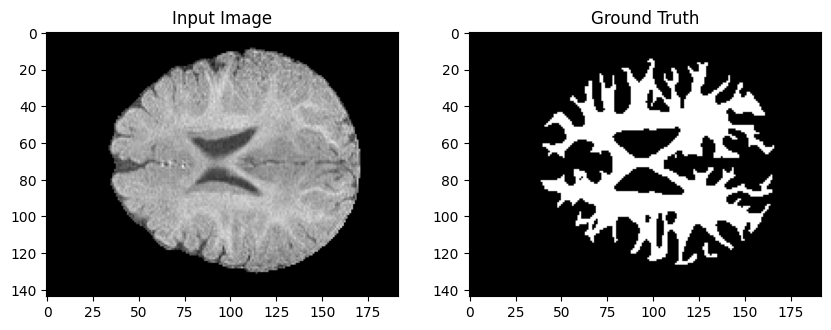

In [64]:
# plotting y_train
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(x_train[150,:,:,0], cmap='gray')
plt.title("Input Image")
plt.subplot(1,2,2)
plt.imshow(y_train[150,:,:,0], cmap='gray')
plt.title("Ground Truth")
plt.show()


In [65]:

nbf64 = 8
nbf128 = 16
nbf256 = 32
nbf512 = 64
nbf1024 = 128

def unet_step3(input_size = (sx,sy,4)):
    inputs = Input(input_size)
    conv1 = Conv2D(nbf64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(nbf64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(nbf128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(nbf128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(nbf256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(nbf256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(nbf512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(nbf512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(nbf1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(nbf1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(nbf512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([up6, conv4], axis = 3)
    conv6 = Conv2D(nbf512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(nbf512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)
    up7 = Conv2D(nbf256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([up7, conv3], axis = 3)
    conv7 = Conv2D(nbf256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(nbf256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)
    up8 = Conv2D(nbf128, 2, activation = 'relu',    padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([up8, conv2], axis = 3)
    conv8 = Conv2D(nbf128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(nbf128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)
    up9 = Conv2D(nbf64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([up9, conv1], axis = 3)
    conv9 = Conv2D(nbf64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(nbf64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)
    model = Model(inputs = inputs, outputs = conv10)
    model.compile(optimizer = Adam(learning_rate = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])
    model.summary()
    return model

In [66]:
model_step3= unet_step3(input_size = (sx,sy,4))

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 144, 192,  │          0 │ -                 │
│ (InputLayer)        │ 4)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_120 (Conv2D) │ (None, 144, 192,  │        296 │ input_layer_5[0]… │
│                     │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_121 (Conv2D) │ (None, 144, 192,  │        584 │ conv2d_120[0][0]  │
│                     │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_20    │ (None, 72, 96, 8) │          0 │ conv2d_121[0][0]  │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_122 (Conv2D) │ (None, 72, 96,    │      1,168 │ max_pooling2d_20… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_123 (Conv2D) │ (None, 72, 96,    │      2,320 │ conv2d_122[0][0]  │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_21    │ (None, 36, 48,    │          0 │ conv2d_123[0][0]  │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_124 (Conv2D) │ (None, 36, 48,    │      4,640 │ max_pooling2d_21… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_125 (Conv2D) │ (None, 36, 48,    │      9,248 │ conv2d_124[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_22    │ (None, 18, 24,    │          0 │ conv2d_125[0][0]  │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_126 (Conv2D) │ (None, 18, 24,    │     18,496 │ max_pooling2d_22… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_127 (Conv2D) │ (None, 18, 24,    │     36,928 │ conv2d_126[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_10          │ (None, 18, 24,    │          0 │ conv2d_127[0][0]  │
│ (Dropout)           │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_23    │ (None, 9, 12, 64) │          0 │ dropout_10[0][0]  │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_128 (Conv2D) │ (None, 9, 12,     │     73,856 │ max_pooling2d_23… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_129 (Conv2D) │ (None, 9, 12,     │    147,584 │ conv2d_128[0][0]  │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_11          │ (None, 9, 12,     │          0 │ conv2d_129[0][0]

 Total params: 486,029 (1.85 MB)

 Trainable params: 486,029 (1.85 MB)

 Non-trainable params: 0 (0.00 B)

In [67]:
if TRAINING_MODE:
    early_stopping = tensorflow.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    model_step3.fit(x_train, y_train, validation_data = (x_validation, y_validation), batch_size = 4, epochs = 50, callbacks=[early_stopping])
    model_step3.save_weights('unet_step3.weights.h5')
else:
    model_step3.load_weights('unet_step3.weights.h5')

On verifie la sementatino

PATIENT for test: subject-8-label.img
T1, T2, VT, prediction


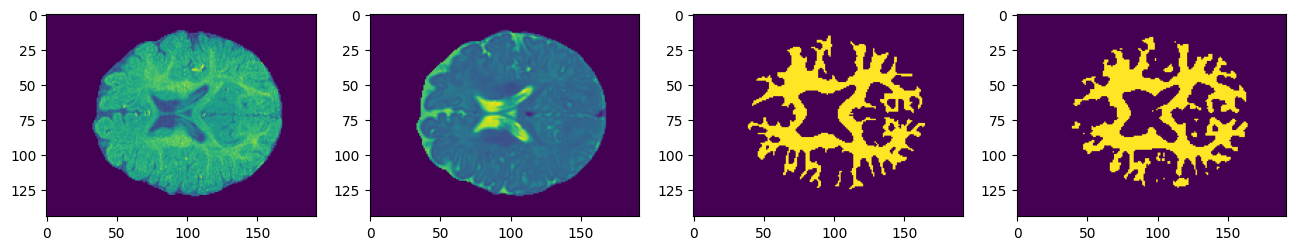

cardIntersec: 184750
cardX: 226256
cardY: 229934
dice: 0.8099695302395932
PATIENT for test: subject-9-label.img
T1, T2, VT, prediction


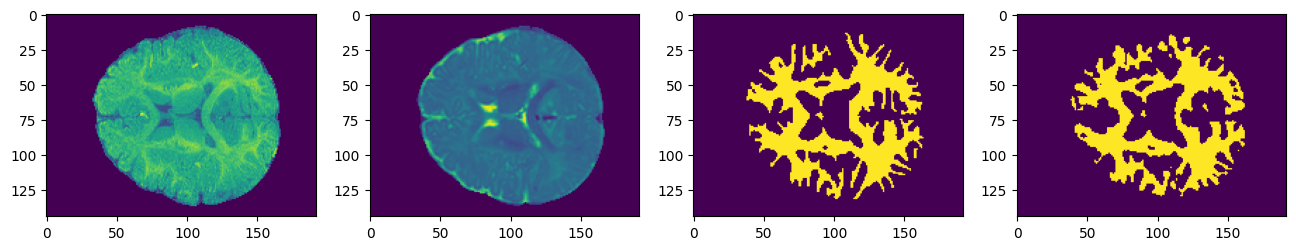

cardIntersec: 246699
cardX: 287871
cardY: 308081
dice: 0.8279156710607566
liste_dices_final: [0.80996953 0.82791567]
Mean dice final: 0.8189426006501749


In [68]:
liste_dices_final = np.zeros((number_of_patient_test,))
numpatient = 0
num_patient_test = 0
for filename in os.listdir(data_folder_path):
    if "label" in filename and "hdr" not in filename:
        if numpatient >= number_of_patient_training + number_of_patient_validation and numpatient < number_of_patient_training + number_of_patient_validation + number_of_patient_test:
            print(f"PATIENT for test: {filename}")
            T1name = filename[:-10]+"-T1.img"
            T1 = nib.load(data_folder_path + T1name).get_fdata()
            T2name = filename[:-10]+"-T2.img"
            T2 = nib.load(data_folder_path+ T2name).get_fdata()
            labels = nib.load(data_folder_path + filename).get_fdata()
        
            sx,sy,sz,_ = labels.shape
            labels = np.array(labels).reshape((sx,sy,sz))

            prediction3D_250 = np.zeros((sx,sy,sz))

            T1NORMALISE = normalization(T1).reshape((sx,sy,sz))
            T2NORMALISE = normalization(T2).reshape((sx,sy,sz))
            VT3D_10 = np.where(labels >= 10,1,0)
            VT3D_150 = np.where(labels >= 150,1,0)
            VT3D_250 = np.where(labels >= 250,1,0)


            for z in range(0,sz):
                inputreseau1 = np.zeros((1,sx,sy,2))
                inputreseau1[0,:,:,0] = T1NORMALISE[:,:,z]
                inputreseau1[0,:,:,1] = T2NORMALISE[:,:,z]

                prediction10 = np.round(model_step1.predict(inputreseau1,verbose=0)).reshape((sx,sy))

                inputreseau2 = np.zeros((1,sx,sy,3))
                inputreseau2[0,:,:,0] = T1NORMALISE[:,:,z]
                inputreseau2[0,:,:,1] = T2NORMALISE[:,:,z]
                inputreseau2[0,:,:,2] = prediction10
                prediction150 = np.round(model_step2.predict(inputreseau2,verbose=0)).reshape((sx,sy))

                inputreseau3 = np.zeros((1,sx,sy,4))
                inputreseau3[0,:,:,0] = T1NORMALISE[:,:,z]
                inputreseau3[0,:,:,1] = T2NORMALISE[:,:,z]
                inputreseau3[0,:,:,2] = prediction10
                inputreseau3[0,:,:,3] = prediction150
                prediction250 = np.round(model_step3.predict(inputreseau3,verbose=0)).reshape((sx,sy))

                prediction3D_250[:,:,z] = np.copy(prediction250)

                prediction_to_plot = np.copy(prediction250)
                VT_to_plot = np.copy(VT3D_250[:,:,z])
                if z == 150 and np.sum(VT_to_plot) > 0:
                    VT_to_plot[0,0] = 1.0
                    prediction_to_plot[0,0] = 1.0
                    print("T1, T2, VT, prediction")
                    fast_display(T1NORMALISE[:,:,z],T2NORMALISE[:,:,z],VT_to_plot,prediction_to_plot)

            dice_final = ComputeDice(prediction3D_250, VT3D_250)
            liste_dices_final[num_patient_test] = dice_final
            num_patient_test += 1
            
        numpatient += 1
print(f"liste_dices_final: {liste_dices_final}")
print(f"Mean dice final: {np.mean(liste_dices_final)}")  

# Finak

In [69]:
liste_dices_250 = np.zeros((number_of_patient_test,))
liste_dices_150 = np.zeros((number_of_patient_test,))
liste_dices_10 = np.zeros((number_of_patient_test,))
numpatient = 0
num_patient_test = 0
for filename in os.listdir(data_folder_path):
    if "label" in filename and "hdr" not in filename:
        if numpatient >= number_of_patient_training + number_of_patient_validation and numpatient < number_of_patient_training + number_of_patient_validation + number_of_patient_test:
            print(f"PATIENT for test: {filename}")
            T1name = filename[:-10]+"-T1.img"
            T1 = nib.load(data_folder_path + T1name).get_fdata()
            T2name = filename[:-10]+"-T2.img"
            T2 = nib.load(data_folder_path+ T2name).get_fdata()
            labels = nib.load(data_folder_path + filename).get_fdata()
        
            sx,sy,sz,_ = labels.shape
            labels = np.array(labels).reshape((sx,sy,sz))

            prediction3D_250 = np.zeros((sx,sy,sz))
            prediction3D_150 = np.zeros((sx,sy,sz))
            prediction3D_10 = np.zeros((sx,sy,sz))

            T1NORMALISE = normalization(T1).reshape((sx,sy,sz))
            T2NORMALISE = normalization(T2).reshape((sx,sy,sz))
            VT3D_10 = np.where(labels >= 10,1,0)
            VT3D_150 = np.where(labels >= 150,1,0)
            VT3D_250 = np.where(labels >= 250,1,0)


            for z in range(0,sz):
                inputreseau1 = np.zeros((1,sx,sy,2))
                inputreseau1[0,:,:,0] = T1NORMALISE[:,:,z]
                inputreseau1[0,:,:,1] = T2NORMALISE[:,:,z]

                prediction10 = np.round(model_step1.predict(inputreseau1,verbose=0)).reshape((sx,sy))

                inputreseau2 = np.zeros((1,sx,sy,3))
                inputreseau2[0,:,:,0] = T1NORMALISE[:,:,z]
                inputreseau2[0,:,:,1] = T2NORMALISE[:,:,z]
                inputreseau2[0,:,:,2] = prediction10
                prediction150 = np.round(model_step2.predict(inputreseau2,verbose=0)).reshape((sx,sy))

                inputreseau3 = np.zeros((1,sx,sy,4))
                inputreseau3[0,:,:,0] = T1NORMALISE[:,:,z]
                inputreseau3[0,:,:,1] = T2NORMALISE[:,:,z]
                inputreseau3[0,:,:,2] = prediction10
                inputreseau3[0,:,:,3] = prediction150
                prediction250 = np.round(model_step3.predict(inputreseau3,verbose=0)).reshape((sx,sy))


                predictionWM  = prediction250
                predictionGM  = np.logical_and(prediction150==1, prediction250==0).astype(np.uint8)
                predictionCSF = np.logical_and(prediction10==1, prediction150==0).astype(np.uint8)


                prediction3D_250[:,:,z] = predictionWM
                prediction3D_150[:,:,z] = predictionGM
                prediction3D_10[:,:,z] = predictionCSF

            dice_final = ComputeDice(prediction3D_250, VT3D_250)
            liste_dices_250[num_patient_test] = dice_final
            dice_final = ComputeDice(prediction3D_150, VT3D_150)
            liste_dices_150[num_patient_test] = dice_final
            dice_final = ComputeDice(prediction3D_10, VT3D_10)
            liste_dices_10[num_patient_test] = dice_final
            num_patient_test += 1
            
        numpatient += 1
print(f"liste_dices_250: {liste_dices_250}")
print(f"Mean dice 250: {np.mean(liste_dices_250)}")
print(f"liste_dices_150: {liste_dices_150}")
print(f"Mean dice 150: {np.mean(liste_dices_150)}")
print(f"liste_dices_10: {liste_dices_10}")
print(f"Mean dice 10: {np.mean(liste_dices_10)}")

PATIENT for test: subject-8-label.img
cardIntersec: 184750
cardX: 226256
cardY: 229934
dice: 0.8099695302395932
cardIntersec: 364729
cardX: 381239
cardY: 602636
dice: 0.741413289289798
cardIntersec: 179368
cardX: 179407
cardY: 786674
dice: 0.37133118237497686
PATIENT for test: subject-9-label.img
cardIntersec: 246699
cardX: 287871
cardY: 308081
dice: 0.8279156710607566
cardIntersec: 389135
cardX: 403107
cardY: 697521
dice: 0.7071144837311062
cardIntersec: 159089
cardX: 159137
cardY: 849853
dice: 0.31534306583811533
liste_dices_250: [0.80996953 0.82791567]
Mean dice 250: 0.8189426006501749
liste_dices_150: [0.74141329 0.70711448]
Mean dice 150: 0.724263886510452
liste_dices_10: [0.37133118 0.31534307]
Mean dice 10: 0.3433371241065461
